# Tarea 6. Distribución óptima de capital y selección de portafolios.

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/en/f/f3/SML-chart.png" width="400px" height="400px" />

**Resumen.**
> En esta tarea, tendrás la oportunidad de aplicar los conceptos y las herramientas que aprendimos en el módulo 3. Específicamente, utilizarás técnicas de optimización media-varianza para construir la frontera de mínima varianza, encontrar el mejor portafolio sobre la frontera mínima varianza, y finalmente, identificar la asignación óptima de capital para un inversionista dado su nivel de averisón al riesgo.

**Criterio de revisión.**
> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Antes de comenzar.**
> Por favor, copiar y pegar este archivo en otra ubicación. Antes de comenzar, nombrarlo *Tarea6_ApellidoNombre*, sin acentos y sin espacios; por ejemplo, en mi caso el archivo se llamaría *Tarea6_JimenezEsteban*. Resolver todos los puntos en dicho archivo y subir en este espacio.

## 1. Datos (10 puntos)

Considere los siguientes datos de bonos, índice de acciones, mercados desarrollados, mercados emergentes, fondos privados, activos reales y activos libres de riesgo:

In [1]:
# Importamos pandas y numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Resumen en base anual de rendimientos esperados y volatilidades
annual_ret_summ = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real', 'Libre_riesgo'], index=['Media', 'Volatilidad'])
annual_ret_summ.loc['Media'] = np.array([0.0400, 0.1060, 0.0830, 0.1190, 0.1280, 0.0620, 0.0300])
annual_ret_summ.loc['Volatilidad'] = np.array([0.0680, 0.2240, 0.2210, 0.3000, 0.2310, 0.0680, None])

annual_ret_summ.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,None


In [3]:
# Matriz de correlación
corr = pd.DataFrame(data= np.array([[1.0000, 0.4000, 0.2500, 0.2000, 0.1500, 0.2000],
                                    [0.4000, 1.0000, 0.7000, 0.6000, 0.7000, 0.2000],
                                    [0.2500, 0.7000, 1.0000, 0.7500, 0.6000, 0.1000],
                                    [0.2000, 0.6000, 0.7500, 1.0000, 0.2500, 0.1500],
                                    [0.1500, 0.7000, 0.6000, 0.2500, 1.0000, 0.3000],
                                    [0.2000, 0.2000, 0.1000, 0.1500, 0.3000, 1.0000]]),
                    columns=annual_ret_summ.columns[:-1], index=annual_ret_summ.columns[:-1])
corr.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Bonos,1.00,0.4,0.25,0.20,0.15,0.20
Acciones,0.40,1.0,0.70,0.60,0.70,0.20
Desarrollado,0.25,0.7,1.00,0.75,0.60,0.10
Emergente,0.20,0.6,0.75,1.00,0.25,0.15
Privados,0.15,0.7,0.60,0.25,1.00,0.30
Real,0.20,0.2,0.10,0.15,0.30,1.00


1. Graficar en el espacio de rendimiento esperado contra volatilidad cada uno de los activos (10 puntos).

In [4]:
rf= annual_ret_summ.loc['Media','Libre_riesgo']
rf

0.03

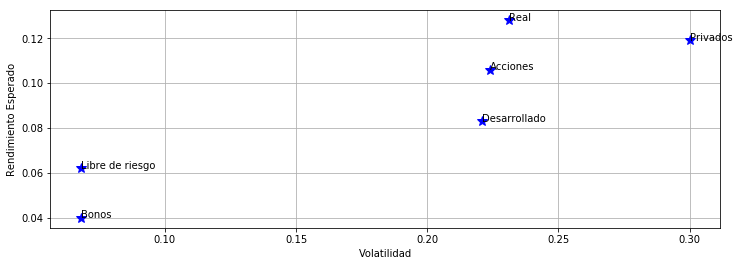

In [4]:
X = annual_ret_summ.loc['Volatilidad']
Y = annual_ret_summ.loc['Media']

plt.figure(figsize=(12,4))

plt.plot(X,Y,'*b', ms=10, label='Activos')
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento Esperado')

plt.text(X[0],Y[0], 'Bonos')
plt.text(X[1],Y[1], 'Acciones')
plt.text(X[2],Y[2], 'Desarrollado')
plt.text(X[3],Y[3], 'Privados')
plt.text(X[4],Y[4], 'Real')
plt.text(X[5],Y[5], 'Libre de riesgo')

plt.grid()
plt.show()

## 2. Hallando portafolios sobre la frontera de mínima varianza (35 puntos)

Usando los datos del punto anterior:

1. Halle los pesos del portafolio de mínima varianza considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
2. Halle los pesos del portafolio EMV considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
3. Halle la covarianza y la correlación entre los dos portafolios hallados (5 puntos)

**2.1 Encontramos portafolio de mínima varianza**

In [5]:
#quitamos rf de nuestro dataframe
data= annual_ret_summ.drop(annual_ret_summ.iloc[:, -1:], axis=1)
data

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Media,0.04,0.106,0.083,0.119,0.128,0.062
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068


In [6]:
# Importamos funcion minimize del modulo optimize de scipy
from scipy.optimize import minimize

In [7]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
S= np.diag(data.loc['Volatilidad'])
Sigma= S.dot(corr).dot(S) 
# 2. rendimientos esperados individuales
Eind= data.loc['Media'].values

# Función objetivo
def var(w, Sigma):
    return w.dot(Sigma).dot(w)
# Dato inicial
n= len(Eind)
w0=np.ones((n,))/n
# Cotas de las variables
bnds= ((0,1),)*n
# Restricciones
cons= {'type': 'eq','fun':lambda w:w.sum()-1}

In [9]:
# Portafolio de mínima varianza
minvar= minimize(fun= var,
                x0=w0,
                args=(Sigma,),
                bounds= bnds,
                constraints=cons)
minvar

     fun: 0.0027745037325952863
     jac: array([0.00551408, 0.00912289, 0.00525779, 0.00714968, 0.00710235,
       0.0055834 ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.95146500e-01, 0.00000000e+00, 2.09837058e-04, 4.33680869e-19,
       0.00000000e+00, 5.04643663e-01])

In [12]:
# Reporte
w_minvar= minvar.x #pesos del portafolio
E_minvar= Eind.dot(w_minvar) #rendimiento del portafolio
s_minvar= np.sqrt(var(w_minvar,Sigma)) #volatilidad del portafolio
RS_minvar= (E_minvar-rf)/s_minvar #Radio de Sharpe
w_minvar,E_minvar, s_minvar, RS_minvar

(array([4.95146500e-01, 0.00000000e+00, 2.09837058e-04, 4.33680869e-19,
        0.00000000e+00, 5.04643663e-01]),
 0.0511111835712562,
 0.0526735581918982,
 0.4007928132431225)

**2.2 Portafolio EMV**

In [13]:
# Función objetivo
def menos_RS(w, Eind, Sigma,rf):
    Ep= Eind.dot(w)
    sp= ((w.dot(Sigma)).dot(w))**0.5
    RS= (Ep-rf)/sp
    return -RS
# Dato inicial
n= len(Eind)
w0=np.ones((n,))/n
# Cotas de las variables
bnds= ((0,1),)*n
# Restricciones
cons= {'type': 'eq','fun':lambda w:w.sum()-1}

In [14]:
# Portafolio EMV
EMV= minimize(fun=menos_RS, 
              x0=w0,
              args=(Eind,Sigma,rf),
              bounds= bnds, 
              constraints=cons)
EMV

     fun: -0.5811986201269204
     jac: array([-0.36522095, -0.28920724, -0.12258474, -0.36597763, -0.36617207,
       -0.36620118])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
       1.65859031e-01, 7.52222174e-01])

In [15]:
# Reporte
w_EMV = EMV.x #pesos EMV
E_EMV = Eind.dot(w_EMV) #rendimiento EMV
s_EMV= (w_EMV.dot(Sigma).dot(w_EMV))**0.5 #volatilidad EMV
RS_EMV= (E_EMV-rf)/s_EMV #Radio de Sharpe EMV
w_EMV, E_EMV, s_EMV, RS_EMV

(array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
        1.65859031e-01, 7.52222174e-01]),
 0.0776160673678556,
 0.0819273579098611,
 0.5811986201269204)

**2.3 Encontrar covarianza y correlación de los portafolios encontrados**

In [16]:
# Covarianza entre los portafolios
s_MV_EMV= w_minvar.dot(Sigma).dot(w_EMV)
# Correlación entre los portafolios
r_MV_EMV= s_MV_EMV/(s_minvar*s_EMV)
s_MV_EMV, r_MV_EMV

(0.0029818190366882494, 0.6909707716261657)

## 3. Frontera de mínima varianza y LAC (30 puntos)

Con los portafolios que se encontraron en el punto anterior (de mínima varianza y EMV):

1. Construya la frontera de mínima varianza calculando el rendimiento esperado y volatilidad para varias combinaciones de los anteriores portafolios. Reportar dichas combinaciones en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).
2. También construya la línea de asignación de capital entre el activo libre de riesgo y el portafolio EMV. Reportar las combinaciones de estos activos en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).

**3.1 Construir frontera de mínima varianza**
Reportar dataframe con pesos, rendimiento, volatilidad y RS

In [22]:
N=101
w=np.linspace(0,6,N)
front_minvar= pd.DataFrame(index= range(1,N+1),
                          data= {'w_EMV':w,
                                'w_minvar': w-1,
                                'Media':w*E_EMV+(1-w)*E_minvar,
                                 'Vol':np.sqrt((w*s_EMV)**2+2*w*(1-w)*s_MV_EMV+((1-w)*s_minvar)**2)}
                                )
front_minvar['RS']=((front_minvar['Media']-rf)/front_minvar['Vol'])
front_minvar.head()

,w_EMV,w_minvar,Media,Vol,RS
1,0.00,-1.00,0.051111,0.052674,0.400793
2,0.06,-0.94,0.052701,0.053029,0.428096
3,0.12,-0.88,0.054292,0.053619,0.453045
4,0.18,-0.82,0.055882,0.054436,0.475458
5,0.24,-0.76,0.057472,0.055470,0.495264


**3.2 LAC portafolio EMV vs. activo libre de riesgo**

In [25]:
#vector wp
wp= np.linspace(0,2,N)

In [29]:
LAC= pd.DataFrame(index= range(len(wp)),
                 data={'wp': wp,
                      'wrf': 1-wp,
                      'Media': wp*E_EMV+(1-wp)*rf,
                      'vol': wp*s_EMV})
LAC['RS']=(LAC['Media']-rf)/LAC['vol']
LAC.head()

,wp,wrf,Media,vol,RS
0,0.00,1.00,0.030000,0.000000,NaN
1,0.02,0.98,0.030952,0.001639,0.581199
2,0.04,0.96,0.031905,0.003277,0.581199
3,0.06,0.94,0.032857,0.004916,0.581199
4,0.08,0.92,0.033809,0.006554,0.581199


## 4. Gráficos y conclusiones (25 puntos)

1. Usando todos los datos obtenidos, grafique:
 - los activos individuales,
 - portafolio de mínima varianza,
 - portafolio eficiente en media-varianza (EMV),
 - frontera de mínima varianza, y
 - línea de asignación de capital,
en el espacio de rendimiento (eje $y$) vs. volatilidad (eje $x$). Asegúrese de etiquetar todo y poner distintos colores para diferenciar los distintos elementos en su gráfico (15 puntos).
2. Suponga que usted está aconsejando a un cliente cuyo coeficiente de aversión al riesgo resultó ser 4. ¿Qué asignación de capital le sugeriría?, ¿qué significa su resultado?(10 puntos)

**4.1 Conjunto de gráficos**

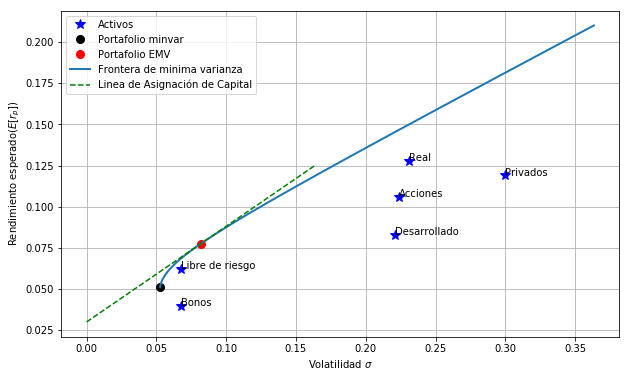

In [53]:
plt.figure(figsize=(10,6))

#Activos individuales
plt.plot(X,Y,'*b', ms=10, label='Activos')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado($E[r_p]$)')

plt.text(X[0],Y[0], 'Bonos')
plt.text(X[1],Y[1], 'Acciones')
plt.text(X[2],Y[2], 'Desarrollado')
plt.text(X[3],Y[3], 'Privados')
plt.text(X[4],Y[4], 'Real')
plt.text(X[5],Y[5], 'Libre de riesgo')
#portafolio de mínima varianza
plt.plot(s_minvar, E_minvar,'ok', ms=8, label='Portafolio minvar')
#portafolio EMV
plt.plot(s_EMV, E_EMV,'or', ms=8, label='Portafolio EMV')
#frontera de mínima varianza
plt.plot(front_minvar['Vol'],front_minvar['Media'],
        lw=2,
        label='Frontera de minima varianza')
#LAC
plt.plot(LAC['vol'],LAC['Media'], 'g--',label='Linea de Asignación de Capital')

plt.legend(loc='best')
plt.grid()
plt.show()

**4.2 Asignación de capital y conclusión**

In [57]:
gamma=4
w_opt= (E_EMV-rf)/(gamma*s_EMV**2)
w_opt

1.7735181353168143

In [62]:
#resultados
1-w_opt, w_opt*w_EMV

(-0.7735181353168143,
 array([2.38165666e-17, 1.80434498e-16, 2.19272585e-16, 1.45284469e-01,
        2.94153999e-01, 1.33407967e+00]))

Segun el coeficiente de aversión al riesgo que tiene nuestro cliente hemos calculado su portafolio eficiente en donde nos pondremos en posición corta en el activo libre de riesgo y posición larga en los demás activos con los pesos ya calculados. 


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>